In [190]:
import pandas as pd
import numpy
import numpy as np
import random
import statistics as st
from scipy.stats import mode, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from datetime import datetime, timedelta
from pmdarima import auto_arima
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, GRU, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [191]:
bnb_df = pd.read_csv("./BNB Historical Data.csv")
bnb_df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2024,601.80,593.80,608.19,593.20,161.02K,1.35%
1,05/31/2024,593.80,594.99,598.89,590.10,175.98K,-0.20%
2,05/30/2024,594.99,595.69,601.80,586.60,233.89K,-0.10%
3,05/29/2024,595.59,601.69,603.59,593.29,219.96K,-1.01%
4,05/28/2024,601.69,603.80,605.48,594.29,294.76K,-0.35%
...,...,...,...,...,...,...,...
1915,03/05/2019,13.65,11.40,13.74,11.40,8.34M,19.61%
1916,03/04/2019,11.41,11.45,11.51,10.88,2.74M,-0.29%
1917,03/03/2019,11.45,11.75,11.86,11.20,2.86M,-2.58%
1918,03/02/2019,11.75,11.35,11.80,10.83,3.89M,3.56%


### Pre-processing Data

In [192]:
print(bnb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1920 non-null   object 
 1   Price     1920 non-null   float64
 2   Open      1920 non-null   float64
 3   High      1920 non-null   float64
 4   Low       1920 non-null   float64
 5   Vol.      1920 non-null   object 
 6   Change %  1920 non-null   object 
dtypes: float64(4), object(3)
memory usage: 105.1+ KB
None


* Định dạng lại cột `Date` để nó trở thành dạng `datetime`
* Xử lý và chuyển đổi kiểu dữ liệu của cột `Vol.` và `Change %` thành kiểu float

In [193]:
bnb_df['Date'] = pd.to_datetime(bnb_df['Date'])
bnb_df['Vol.'] = bnb_df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').fillna('0')
bnb_df['Vol.'] = bnb_df['Vol.'].astype(float)
bnb_df['Change %'] = bnb_df['Change %'].str.replace('%', '').astype(float)
bnb_df.reset_index(drop=True)
bnb_df.set_index('Date', inplace=True)
bnb_df.sort_index(ascending=True, inplace=True)
bnb_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,11.35,10.27,11.55,10.24,4020000.0,10.45
2019-03-02,11.75,11.35,11.80,10.83,3890000.0,3.56
2019-03-03,11.45,11.75,11.86,11.20,2860000.0,-2.58
2019-03-04,11.41,11.45,11.51,10.88,2740000.0,-0.29
2019-03-05,13.65,11.40,13.74,11.40,8340000.0,19.61
...,...,...,...,...,...,...
2024-05-28,601.69,603.80,605.48,594.29,294760.0,-0.35
2024-05-29,595.59,601.69,603.59,593.29,219960.0,-1.01
2024-05-30,594.99,595.69,601.80,586.60,233890.0,-0.10


In [194]:
missing_values = bnb_df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [195]:
print(bnb_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1920 non-null   float64
 1   Open      1920 non-null   float64
 2   High      1920 non-null   float64
 3   Low       1920 non-null   float64
 4   Vol.      1920 non-null   float64
 5   Change %  1920 non-null   float64
dtypes: float64(6)
memory usage: 105.0 KB
None


In [196]:
bnb_description = bnb_df.describe()
bnb_description

,Price,Open,High,Low,Vol.,Change %
count,1920.000000,1920.000000,1920.000000,1920.000000,1.920000e+03,1920.000000
mean,229.552547,229.245161,235.806146,222.272714,4.316261e+06,0.329344
std,184.430107,184.300217,189.692063,178.382323,2.135747e+07,4.891566
min,9.250000,9.250000,10.410000,6.500000,8.993000e+04,-44.080000
25%,27.030000,27.027500,27.807500,26.082500,5.633800e+05,-1.610000
50%,247.550000,247.055000,254.285000,242.050000,1.600000e+06,0.130000
75%,332.110000,331.345000,339.792500,322.325000,3.772500e+06,2.160000
max,676.560000,676.250000,690.870000,634.810000,3.995400e+08,69.990000


In [197]:
# Descriptive statistics for Price
print('More Price Statistics:')

print('Mode:', bnb_df['Price'].mode().values[0])
print('Standard Deviation:', bnb_df['Price'].std())
print('Variance:', bnb_df['Price'].var())
print('Kurtosis:', bnb_df['Price'].kurt())
print('Skewness:', bnb_df['Price'].skew())

More Price Statistics:
Mode: 23.01
Standard Deviation: 184.43010721388004
Variance: 34014.46444692328
Kurtosis: -0.8960616714167435
Skewness: 0.33018718587724455


##### Price by Date Plot

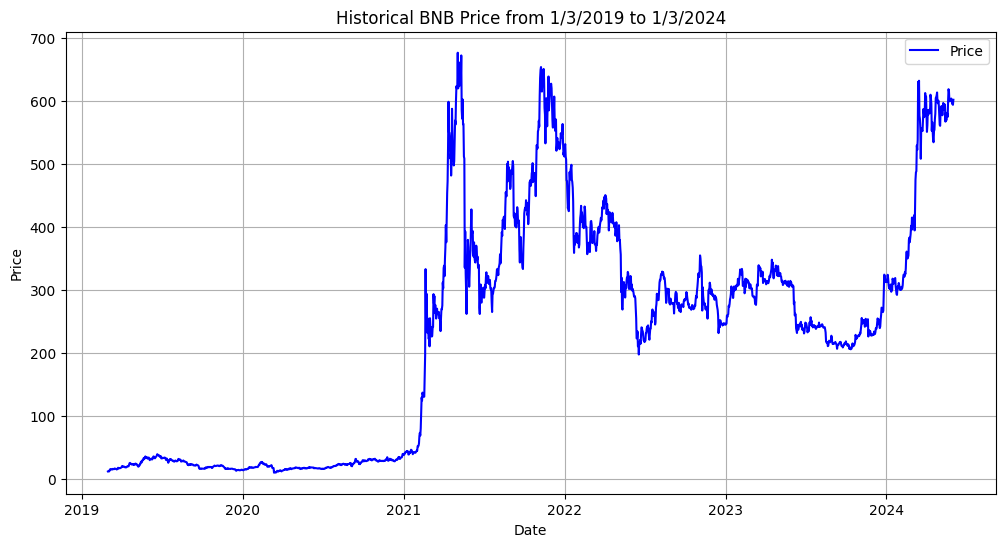

In [198]:
plt.figure(figsize=(12, 6))
plt.plot(bnb_df['Price'], label='Price', color='b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical BNB Price from 1/3/2019 to 1/3/2024')
plt.legend()
plt.grid(True)
plt.show()


##### Boxplot for Price

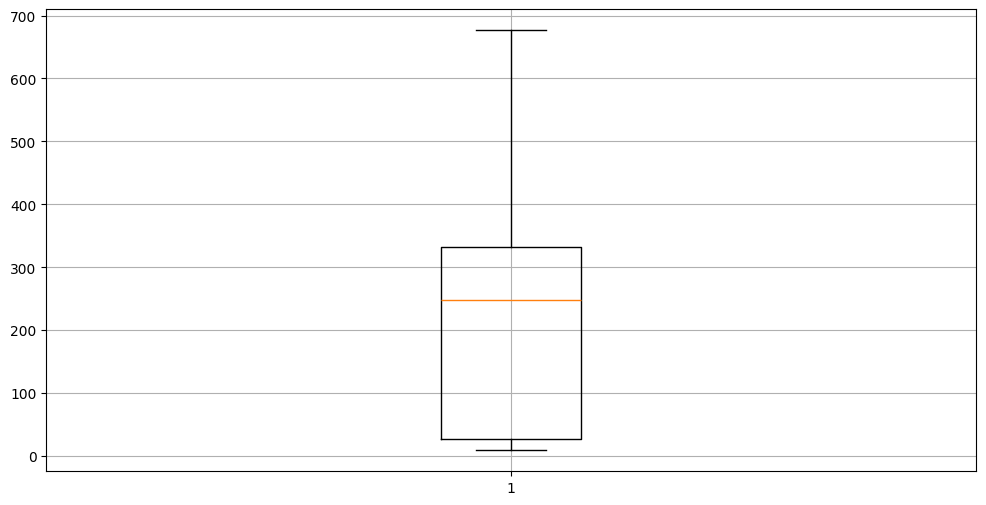

In [199]:
plt.figure(figsize=(12, 6))
plt.boxplot(bnb_df['Price'])
plt.grid()
plt.show()

### Parameter

In [200]:
window_size = 10
feature_dim = 5
test_size=0.2

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 100
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

### Split data

In [201]:
train_ratio = 0.6
test_ratio = 0.4

In [202]:
train_data = int(len(bnb_df)*train_ratio)
test_data = train_data + int(len(bnb_df)*test_ratio)

print('train index: ',train_data)
print('test index: ',test_data)

train index:  1152
test index:  1920


In [203]:
train_df = bnb_df.iloc[:train_data]
test_df  = bnb_df[train_data:test_data]

index_30 = random.randint(0, len(bnb_df) - 100)
index_60 =random.randint(0, len(bnb_df) - 100)
index_90 =random.randint(0, len(bnb_df) - 100)

df_30 = bnb_df.iloc[index_30: index_30+30]
df_60 = bnb_df.iloc[index_60: index_60+60]
df_90 = bnb_df.iloc[index_90: index_90+90]

date_range_30 = pd.date_range(start='2024-06-02', end='2024-07-02', periods=30)
date_range_60 = pd.date_range(start='2024-06-02', end='2024-08-01', periods=60)
date_range_90 = pd.date_range(start='2024-02-06', end='2024-08-31', periods=90)

df_30.index = date_range_30.date
df_60.index = date_range_60.date
df_90.index = date_range_90.date

print('df_train.shape: ',train_df.shape)
print('df_test.shape: ',test_df.shape)
print('df_30.shape: ',df_30.shape)
print('df_60.shape: ',df_60.shape)
print('df_90.shape: ',df_90.shape)

df_train.shape:  (1152, 6)
df_test.shape:  (768, 6)
df_30.shape:  (30, 6)
df_60.shape:  (60, 6)
df_90.shape:  (90, 6)


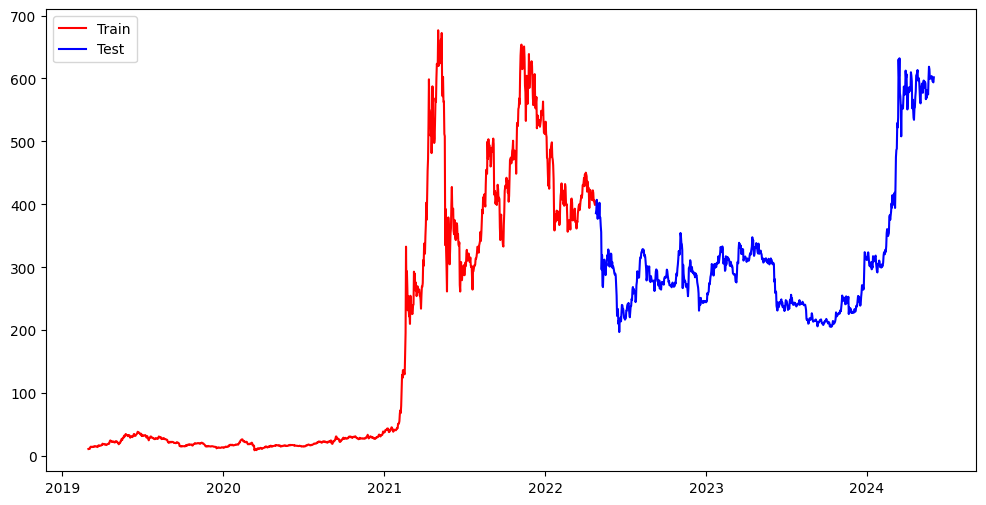

In [204]:
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(train_df).index.to_list(), pd.DataFrame(train_df['Price']), color='r', label='Train')
plt.plot(pd.DataFrame(test_df).index.to_list(),pd.DataFrame(test_df['Price']),color='b' ,label ='Test')
plt.legend()
plt.show()

In [205]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)
df_30_scaled = scaler.transform(df_30)
df_60_scaled = scaler.transform(df_60)
df_90_scaled = scaler.transform(df_90)

train_df_scaled = pd.DataFrame(train_df_scaled, index=train_df.index, columns=train_df.columns)
test_df_scaled = pd.DataFrame(test_df_scaled, index=test_df.index, columns=test_df.columns)
df_30_scaled = pd.DataFrame(df_30_scaled,index =df_30.index,columns=df_30.columns)
df_60_scaled = pd.DataFrame(df_60_scaled,index =df_60.index,columns=df_60.columns)
df_90_scaled = pd.DataFrame(df_90_scaled,index =df_90.index,columns=df_90.columns)

In [206]:
print('train_df_scaled shape: ',train_df_scaled.shape)
print('test_df_scaled shape: ',test_df_scaled.shape)
print('df_30_scaled shape: ',df_30_scaled.shape)
print('df_60_scaled shape: ',df_60_scaled.shape)
print('df_90_scaled shape: ',df_90_scaled.shape)

train_df_scaled shape:  (1152, 6)
test_df_scaled shape:  (768, 6)
df_30_scaled shape:  (30, 6)
df_60_scaled shape:  (60, 6)
df_90_scaled shape:  (90, 6)


In [207]:
# Define the target variable
target = 'Price'

In [208]:
# Split data into features and target
X_train = train_df_scaled.drop(columns=target).values
y_train = train_df_scaled[target]

X_test = test_df_scaled.drop(columns=target).values
y_test = test_df_scaled[target]

X_30_scaled = df_30_scaled.drop(columns=target).values
y_30_scaled = df_30_scaled[target]

X_60_scaled = df_60_scaled.drop(columns=target).values
y_60_scaled = df_60_scaled[target]

X_90_scaled = df_90_scaled.drop(columns=target).values
y_90_scaled = df_90_scaled[target]

In [209]:
print('X_train_scaled shape: ',X_train.shape)
print('y_train_scaled shape: ',y_train.shape)
print('\nX_test_scaled shape: ',X_test.shape)
print('y_test_scaled shape: ',y_test.shape)
print('\nX_30_scaled shape: ',X_30_scaled.shape)
print('y_30_scaled shape: ',y_30_scaled.shape)
print('\nX_60_scaled shape: ',X_60_scaled.shape)
print('y_60_scaled shape: ',y_60_scaled.shape)
print('\nX_90_scaled shape: ',X_90_scaled.shape)
print('y_90_scaled shape: ',y_90_scaled.shape)

X_train_scaled shape:  (1152, 5)
y_train_scaled shape:  (1152,)

X_test_scaled shape:  (768, 5)
y_test_scaled shape:  (768,)

X_30_scaled shape:  (30, 5)
y_30_scaled shape:  (30,)

X_60_scaled shape:  (60, 5)
y_60_scaled shape:  (60,)

X_90_scaled shape:  (90, 5)
y_90_scaled shape:  (90,)


### Model Training

#### Linear Regression

In [210]:
X_train_lr = X_train
y_train_lr = y_train

X_test_lr  = X_test
y_test_lr = y_test

X_30_lr = X_30_scaled
X_60_lr = X_60_scaled
X_90_lr = X_90_scaled

In [211]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_lr, y_train_lr)

# Make predictions
y_pred_test_lr = model.predict(X_test_lr)
pred_30_lr = model.predict(X_30_lr)
pred_60_lr = model.predict(X_60_lr)
pred_90_lr = model.predict(X_90_lr)

##### Evaluate Linear Regression

In [212]:
# Evaluate model on test set
mape_test_lr = mean_absolute_percentage_error(y_test_lr, y_pred_test_lr)
mae_test_lr = mean_absolute_error(y_test_lr, y_pred_test_lr)
rmse_test_lr = root_mean_squared_error(y_test_lr, y_pred_test_lr)

print("Test Set MAPE: ", mape_test_lr)
print("Test Set MAE: ", mae_test_lr)
print("Test Set RMSE: ", rmse_test_lr)

Test Set MAPE:  0.007916063154177734
Test Set MAE:  0.0036641669502971478
Test Set RMSE:  0.006025621146694611


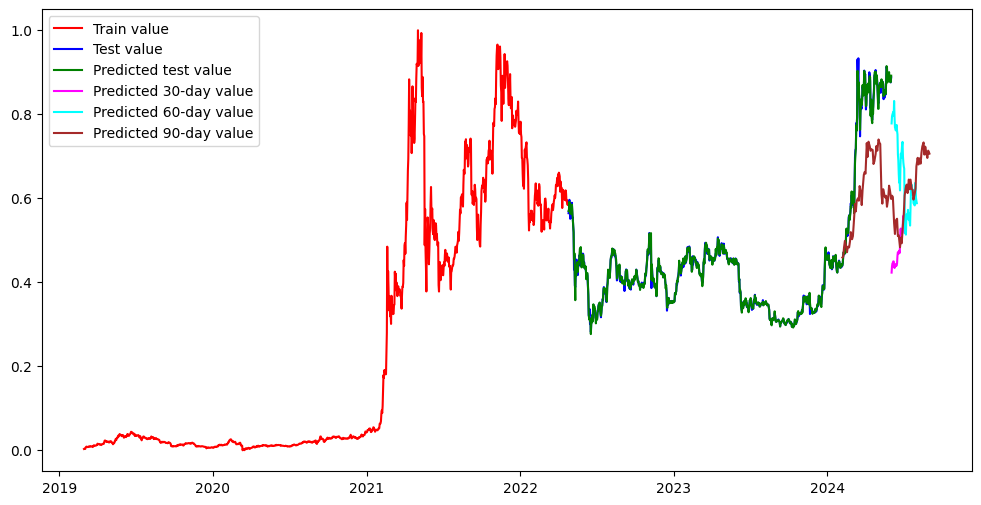

In [213]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_pred_test_lr.reshape(-1)), color='g', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scaled).index.to_list(),pd.DataFrame(pred_30_lr.reshape(-1)),color='magenta', label='Predicted 30-day value')
plt.plot(pd.DataFrame(y_60_scaled).index.to_list(), pd.DataFrame(pred_60_lr.reshape(-1)), color='cyan', label='Predicted 60-day value')
plt.plot(pd.DataFrame(y_90_scaled).index.to_list(), pd.DataFrame(pred_90_lr.reshape(-1)), color='brown', label='Predicted 90-day value')
plt.legend()
plt.show()

#### ARIMA

In [214]:
X_30_arima = X_30_scaled.reshape((X_30_scaled.shape[0], 1, X_30_scaled.shape[1]))
X_60_arima = X_60_scaled.reshape((X_60_scaled.shape[0], 1, X_60_scaled.shape[1]))
X_90_arima = X_90_scaled.reshape((X_90_scaled.shape[0], 1, X_90_scaled.shape[1]))

In [215]:
stepwise_model = auto_arima(y_train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=1,
                            start_P=0, seasonal=False,
                            d=None, D=0, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5462.649, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5437.064, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5459.970, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5456.339, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5438.483, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5462.389, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5464.188, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5466.364, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5466.289, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5462.368, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5467.716, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5457.569, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5466.969, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-5467.699, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0

In [216]:
y_pred_test_arima = stepwise_model.predict(n_periods=len(X_test))
pred_30_arima = stepwise_model.predict(n_periods=len(X_30_arima))
pred_60_arima = stepwise_model.predict(n_periods=len(X_60_arima))
pred_90_arima = stepwise_model.predict(n_periods=len(X_90_arima))

mape_test_arima = mean_absolute_percentage_error(y_test, y_pred_test_arima)
mae_test_arima = mean_absolute_error(y_test, y_pred_test_arima)
rmse_test_arima = root_mean_squared_error(y_test, y_pred_test_arima)

print("Test Set MAPE: ", mape_test_arima)
print("Test Set MAE: ", mae_test_arima)
print("Test Set RMSE: ", rmse_test_arima)

Test Set MAPE:  0.479978638040663
Test Set MAE:  0.19554988071149002
Test Set RMSE:  0.20709572637673346


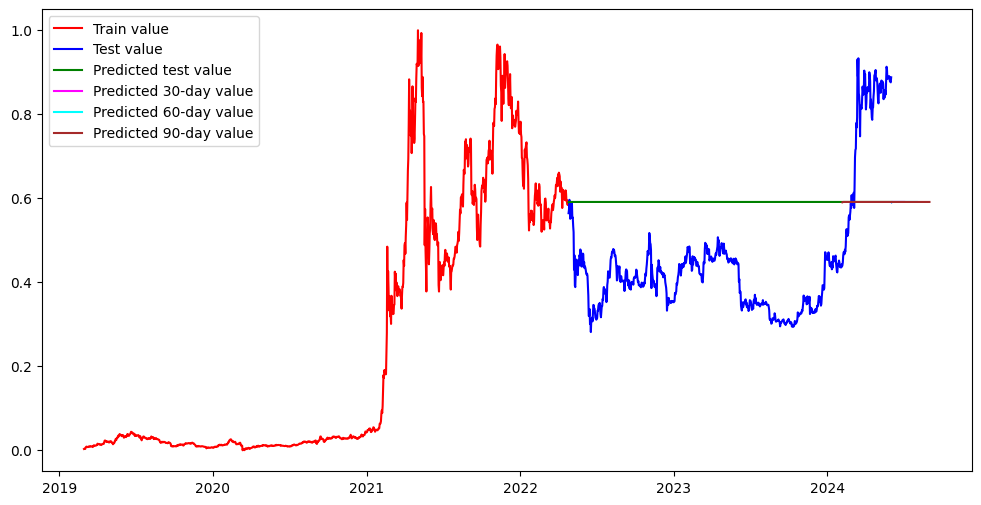

In [217]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_pred_test_arima), color='g', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scaled).index.to_list(),pd.DataFrame(pred_30_arima),color='magenta', label='Predicted 30-day value')
plt.plot(pd.DataFrame(y_60_scaled).index.to_list(), pd.DataFrame(pred_60_arima), color='cyan', label='Predicted 60-day value')
plt.plot(pd.DataFrame(y_90_scaled).index.to_list(), pd.DataFrame(pred_90_arima), color='brown', label='Predicted 90-day value')
plt.legend()
plt.show()

#### GRU

In [218]:
X_train_GRU = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_GRU = y_train.values


X_test_GRU = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_GRU = y_test

X_30_GRU = X_30_scaled.reshape((X_30_scaled.shape[0], 1, X_30_scaled.shape[1]))
X_60_GRU = X_60_scaled.reshape((X_60_scaled.shape[0], 1, X_60_scaled.shape[1]))
X_90_GRU = X_90_scaled.reshape((X_90_scaled.shape[0], 1, X_90_scaled.shape[1]))

In [219]:
# Xây dựng mô hình GRU
model_GRU = Sequential()
model_GRU.add(GRU(50, return_sequences=True, input_shape=(1, X_train_GRU.shape[2])))
model_GRU.add(GRU(50, return_sequences=False))
model_GRU.add(Dense(25))
model_GRU.add(Dense(1))

# Compile mô hình
model_GRU.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
history_GRU = model_GRU.fit(X_train_GRU, y_train_GRU, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


c:\Users\VU HOANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1192
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0230 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012     
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8509e-04 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7527e-04 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1377e-04 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6342e-04 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6899e-04 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7005e-04 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4352e-04 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4060e-04 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2365e-04 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2781e-04 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3644e-04 
Epoch 15/100
18/18 ━━━

In [220]:
# Compile mô hình
model_GRU.compile(optimizer='adam', loss='mean_squared_error')

In [221]:
# Dự đoán giá
test_predict_GRU = model_GRU.predict(X_test_GRU)
pred_30_GRU = model_GRU.predict(X_30_GRU)
pred_60_GRU = model_GRU.predict(X_60_GRU)
pred_90_GRU = model_GRU.predict(X_90_GRU)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [222]:
mape_test_GRU = mean_absolute_percentage_error(y_test_GRU, test_predict_GRU)
mae_test_GRU = mean_absolute_error(y_test_GRU, test_predict_GRU)
rmse_test_GRU = root_mean_squared_error(y_test_GRU, test_predict_GRU)

print("Test Set MAPE: ", mape_test_GRU)
print("Test Set MAE: ", mae_test_GRU)
print("Test Set RMSE: ", rmse_test_GRU)

Test Set MAPE:  0.005739184124433329
Test Set MAE:  0.002679185680384643
Test Set RMSE:  0.0044393864014231205


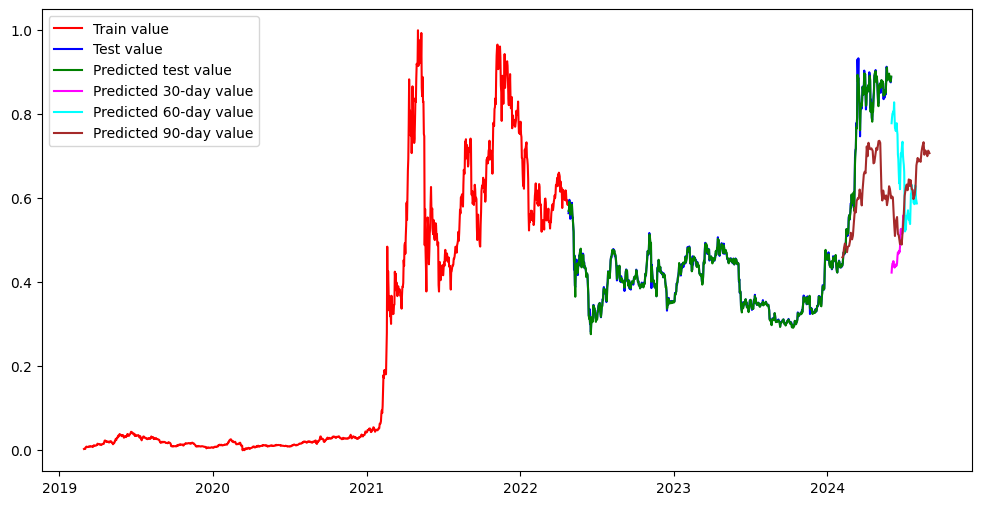

In [223]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(test_predict_GRU), color='g', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scaled).index.to_list(),pd.DataFrame(pred_30_GRU),color='magenta', label='Predicted 30-day value')
plt.plot(pd.DataFrame(y_60_scaled).index.to_list(), pd.DataFrame(pred_60_GRU), color='cyan', label='Predicted 60-day value')
plt.plot(pd.DataFrame(y_90_scaled).index.to_list(), pd.DataFrame(pred_90_GRU), color='brown', label='Predicted 90-day value')
plt.legend()
plt.show()

#### RNN

In [224]:
X_train_RNN = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_RNN = y_train.values

X_test_RNN = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_RNN = y_test.values

X_30_RNN = X_30_scaled.reshape((X_30_scaled.shape[0], 1, X_30_scaled.shape[1]))
X_60_RNN = X_60_scaled.reshape((X_60_scaled.shape[0], 1, X_60_scaled.shape[1]))
X_90_RNN = X_90_scaled.reshape((X_90_scaled.shape[0], 1, X_90_scaled.shape[1]))

In [225]:
def build_RNN_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'): 
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(optimizer='adam', loss='mse')

    model.compile(loss =loss, optimizer=optimizer)
    return model

In [226]:
model_RNN = build_RNN_model((X_train_RNN.shape[1],X_train_RNN.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

c:\Users\VU HOANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [227]:
history = model_RNN.fit(
    X_train_RNN, y_train_RNN, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [228]:
test_predict_RNN = model_RNN.predict(X_test_RNN)
pred_30_RNN = model_RNN.predict(X_30_RNN)
pred_60_RNN = model_RNN.predict(X_60_RNN)
pred_90_RNN = model_RNN.predict(X_90_RNN)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [229]:
mape_test_RNN = mean_absolute_percentage_error(y_test_RNN, test_predict_RNN)
mae_test_RNN = mean_absolute_error(y_test_RNN, test_predict_RNN)
rmse_test_RNN = root_mean_squared_error(y_test_RNN, test_predict_RNN)

print("Test Set MAPE: ", mape_test_RNN)
print("Test Set MAE: ", mae_test_RNN)
print("Test Set RMSE: ", rmse_test_RNN)

Test Set MAPE:  0.016255739355284633
Test Set MAE:  0.0073368718288930575
Test Set RMSE:  0.008066736197498618


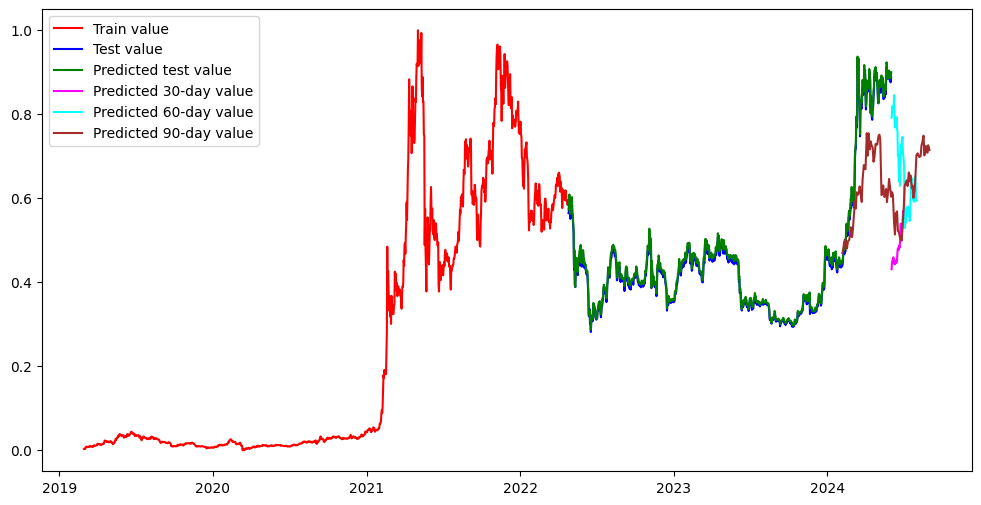

In [230]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(test_predict_RNN), color='g', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scaled).index.to_list(),pd.DataFrame(pred_30_RNN),color='magenta', label='Predicted 30-day value')
plt.plot(pd.DataFrame(y_60_scaled).index.to_list(), pd.DataFrame(pred_60_RNN), color='cyan', label='Predicted 60-day value')
plt.plot(pd.DataFrame(y_90_scaled).index.to_list(), pd.DataFrame(pred_90_RNN), color='brown', label='Predicted 90-day value')
plt.legend()
plt.show()

#### LSTM

In [231]:
X_train_LSTM = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_LSTM = y_train.values

X_test_LSTM = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_LSTM = y_test.values

X_30_LSTM = X_30_scaled.reshape((X_30_scaled.shape[0], 1, X_30_scaled.shape[1]))
X_60_LSTM = X_60_scaled.reshape((X_60_scaled.shape[0], 1, X_60_scaled.shape[1]))
X_90_LSTM = X_90_scaled.reshape((X_90_scaled.shape[0], 1, X_90_scaled.shape[1]))

In [232]:
def build_lstm_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [233]:
model_LSTM = build_lstm_model(
    (X_train_LSTM.shape[1],X_train_LSTM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

c:\Users\VU HOANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [234]:
history = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [235]:
test_predict_LSTM = model_LSTM.predict(X_test_LSTM)
pred_30_LSTM = model_LSTM.predict(X_30_LSTM)
pred_60_LSTM = model_LSTM.predict(X_60_LSTM)
pred_90_LSTM = model_LSTM.predict(X_90_LSTM)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [236]:
mape_test_LSTM = mean_absolute_percentage_error(y_test_LSTM, test_predict_LSTM)
mae_test_LSTM = mean_absolute_error(y_test_LSTM, test_predict_LSTM)
rmse_test_LSTM = root_mean_squared_error(y_test_LSTM, test_predict_LSTM)

print("Test Set MAPE: ", mape_test_LSTM)
print("Test Set MAE: ", mae_test_LSTM)
print("Test Set RMSE: ", rmse_test_LSTM)

Test Set MAPE:  0.009802379710392065
Test Set MAE:  0.004211615066612083
Test Set RMSE:  0.005638093449804184


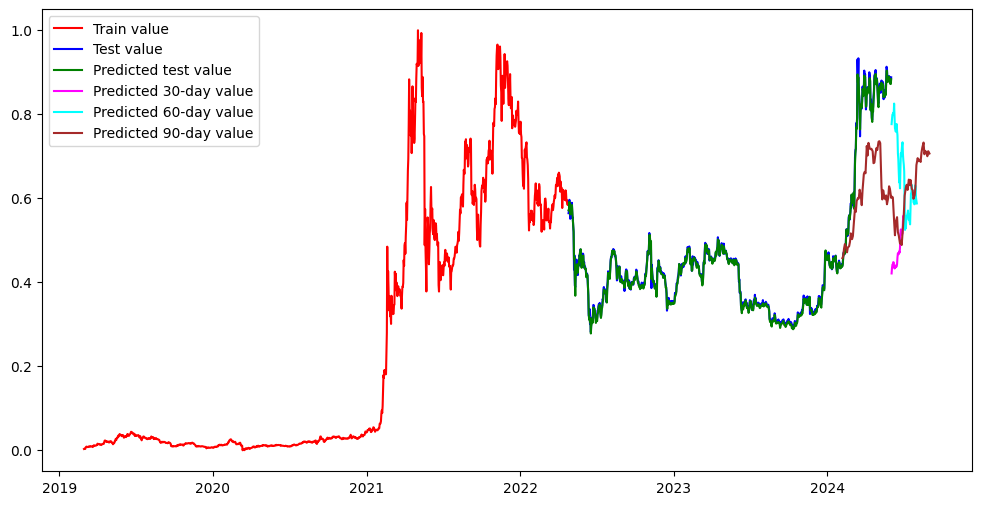

In [237]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(test_predict_LSTM), color='g', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scaled).index.to_list(),pd.DataFrame(pred_30_LSTM),color='magenta', label='Predicted 30-day value')
plt.plot(pd.DataFrame(y_60_scaled).index.to_list(), pd.DataFrame(pred_60_LSTM), color='cyan', label='Predicted 60-day value')
plt.plot(pd.DataFrame(y_90_scaled).index.to_list(), pd.DataFrame(pred_90_LSTM), color='brown', label='Predicted 90-day value')
plt.legend()
plt.show()